In [6]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [7]:
df_train = pd.read_csv('train_processed_isolation_forest.csv')
df_train.head(10)


,employee_id,date,employee_seniority_years,num_print_commands,total_printed_pages,num_print_commands_off_hours,num_printed_pages_off_hours,num_color_prints,num_bw_prints,ratio_color_prints,...,month_freq_quartile,is_end_of_month_binary_zscore,is_quarter_end_binary_zscore,high_classification_burn_binary_zscore,is_heavy_burner_binary_zscore,is_heavy_printer_binary_zscore,is_employee_in_origin_country_binary_zscore,is_new_employee_binary_zscore,is_veteran_employee_binary_zscore,is_malicious
0,849,2025-05-14,0.820369,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,1.685542,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,1
1,1370,2025-06-07,-0.937306,1.211276,0.275436,-0.188799,-0.079475,-0.2373,0.420338,0.923207,...,-0.182319,-0.508422,1.397213,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,-1.197962,0
2,726,2025-04-09,-0.126071,0.848355,0.275436,-0.188799,-0.079475,-0.2373,0.420338,0.389968,...,-0.182319,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
3,711,2025-04-03,0.955575,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,-0.182319,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
4,779,2025-03-14,0.820369,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,0.751611,-0.508422,1.397213,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
5,70,2025-04-07,-1.207717,0.122514,-0.133224,-0.188799,-0.079475,-0.2373,-0.196152,0.219656,...,-0.182319,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,-1.197962,0
6,313,2025-06-15,0.820369,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,-0.182319,-0.508422,1.397213,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
7,481,2025-04-07,-0.126071,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,-0.182319,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
8,760,2025-01-31,2.037221,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,-1.116249,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0
9,1494,2025-05-18,0.955575,-0.603326,-0.325535,-0.188799,-0.079475,-0.2373,-0.350274,-0.558013,...,1.685542,-0.508422,-0.715710,-0.071885,-0.472213,-0.445172,-0.013748,-0.135203,0.834751,0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179928 entries, 0 to 179927
Columns: 130 entries, employee_id to is_malicious
dtypes: float64(125), int64(2), object(3)
memory usage: 178.5+ MB


In [9]:
non_numeric_cols = df_train.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)


Index(['date', 'first_entry_time', 'last_exit_time'], dtype='object')


In [10]:
df_train.drop(['date', 'first_entry_time', 'last_exit_time'], axis=1, inplace=True)


In [11]:
for col in non_numeric_cols:
    print(f"\nColumn: {col}")
    print(df_train[[col]].head(2))


Column: date


KeyError: "None of [Index(['date'], dtype='object')] are in the [columns]"

In [ ]:
# אימון Isolation Forest
model = IsolationForest(n_estimators=200, contamination=0.05, random_state=42, n_jobs=-1)
model.fit(df_train)


,n_estimators,200
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:

# ------------------------
# 1. Load datasets
# ------------------------
df_train = pd.read_csv('train_processed_isolation_forest.csv')
df_test  = pd.read_csv('test_processed_isolation_forest.csv')
df_eval  = pd.read_csv('val_processed_isolation_forest.csv')


In [ ]:

# הורדת עמודות לא רלוונטיות אם קיימות
drop_cols = ['date', 'first_entry_time', 'last_exit_time']
for col in drop_cols:
    for df in [df_train, df_test, df_eval]:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)


In [ ]:
df_train.columns


Index(['employee_id', 'employee_seniority_years', 'num_print_commands',
       'total_printed_pages', 'num_print_commands_off_hours',
       'num_printed_pages_off_hours', 'num_color_prints', 'num_bw_prints',
       'ratio_color_prints', 'num_burn_requests',
       ...
       'month_freq_quartile', 'is_end_of_month_binary_zscore',
       'is_quarter_end_binary_zscore',
       'high_classification_burn_binary_zscore',
       'is_heavy_burner_binary_zscore', 'is_heavy_printer_binary_zscore',
       'is_employee_in_origin_country_binary_zscore',
       'is_new_employee_binary_zscore', 'is_veteran_employee_binary_zscore',
       'is_malicious'],
      dtype='object', length=127)

In [ ]:

# ------------------------
# 2. Train Isolation Forest
# ------------------------
model = IsolationForest(
    n_estimators=300,
    contamination=0.05,     # שיעור הדגימות החריגות שאתה מצפה
    max_samples='auto',     # דגימה אוטומטית מהדאטה
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model.fit(df_train)



[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:    0.3s remaining:    3.3s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.7s finished


,n_estimators,300
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,1
,warm_start,False


In [ ]:
# ------------------------
# 3. Predict on all sets
# ------------------------
def apply_model(df, name="Set"):
    scores = model.decision_function(df)
    preds = model.predict(df)  # -1 = anomaly, 1 = normal

    df_out = df.copy()
    df_out['anomaly_score'] = scores
    df_out['prediction'] = preds

    print(f"\n📊 Summary for {name}:")
    print(df_out['prediction'].value_counts())
    return df_out

df_train_pred = apply_model(df_train, "TRAIN")
df_test_pred  = apply_model(df_test, "TEST")
df_eval_pred  = apply_model(df_eval, "EVAL")


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s



📊 Summary for TRAIN:
prediction
 1    170931
-1      8997
Name: count, dtype: int64


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished



📊 Summary for TEST:
prediction
 1    56930
-1     3046
Name: count, dtype: int64


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s



📊 Summary for EVAL:
prediction
 1    56970
-1     3006
Name: count, dtype: int64


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished


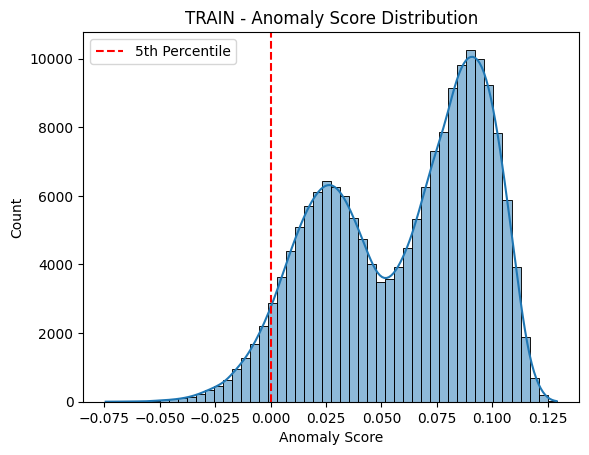

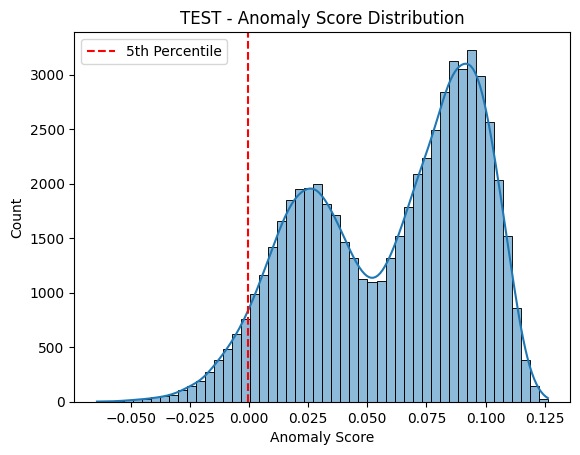

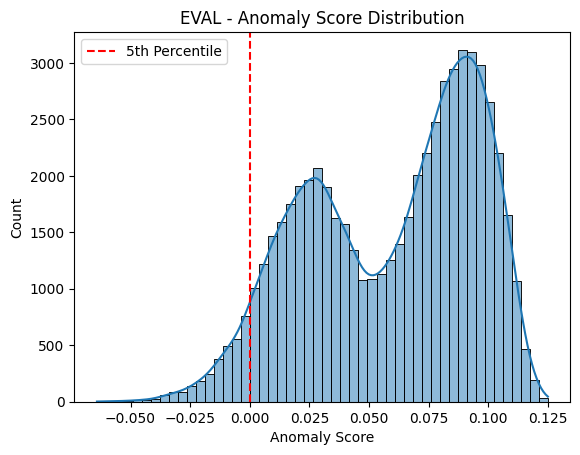

In [ ]:

# ------------------------
# 4. Visual Analysis
# ------------------------
def plot_anomaly_distribution(df_pred, title):
    sns.histplot(df_pred['anomaly_score'], bins=50, kde=True)
    plt.title(f"{title} - Anomaly Score Distribution")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Count")
    plt.axvline(x=np.percentile(df_pred['anomaly_score'], 5), color='red', linestyle='--', label='5th Percentile')
    plt.legend()
    plt.show()

plot_anomaly_distribution(df_train_pred, "TRAIN")
plot_anomaly_distribution(df_test_pred, "TEST")
plot_anomaly_distribution(df_eval_pred, "EVAL")



In [ ]:
# ------------------------
# 5. Optional: Analyze top anomalies
# ------------------------
def get_top_anomalies(df_pred, top_n=10):
    return df_pred.sort_values(by='anomaly_score').head(top_n)

top_anomalies_train = get_top_anomalies(df_train_pred)
top_anomalies_test  = get_top_anomalies(df_test_pred)

print("\n🕵️‍♂️ Top anomalies in TRAIN:")
print(top_anomalies_train)

print("\n🕵️‍♂️ Top anomalies in TEST:")
print(top_anomalies_test)



🕵️‍♂️ Top anomalies in TRAIN:
        employee_id  employee_seniority_years  num_print_commands  \
55651           128                 -1.072512            2.118577   
78443           128                 -1.072512            0.848355   
66599            25                 -1.342923            0.848355   
48396           128                 -1.072512            2.118577   
178235           24                 -0.802100            2.118577   
19884          1666                 -0.261277            2.118577   
131759         1000                 -0.531689            0.485435   
1876            197                  0.549958            2.118577   
2489             71                  0.009135           -0.240406   
1472             24                 -0.802100            1.574196   

        total_printed_pages  num_print_commands_off_hours  \
55651              0.275436                     -0.188799   
78443              0.275436                     -0.188799   
66599              0.27543

In [ ]:
df_train_pred['prediction'].value_counts()


prediction
 1    170931
-1      8997
Name: count, dtype: int64

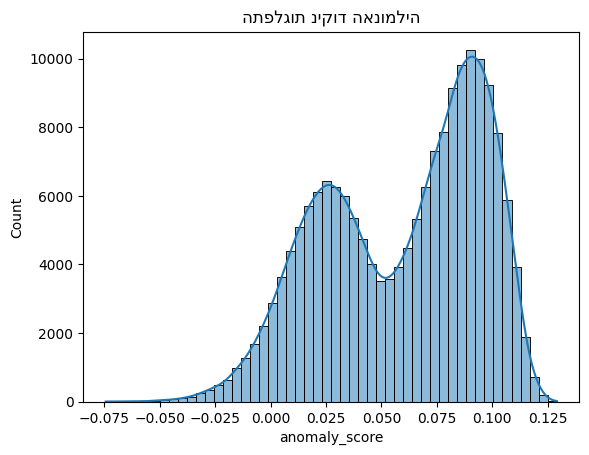

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_train_pred['anomaly_score'], bins=50, kde=True)
plt.title("התפלגות ניקוד האנומליה")
plt.show()


In [15]:
# 1. Train the model
model = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
model.fit(df_train)

# 2. Predict
def apply_model(df):
    df_out = df.copy()
    df_out['anomaly_score'] = model.decision_function(df)
    df_out['prediction'] = model.predict(df)
    return df_out

df_train_pred = apply_model(df_train)
df_test_pred = apply_model(df_test)
df_eval_pred = apply_model(df_eval)

# 3. Evaluate
def evaluate_set(df, name="SET"):
    y_true = df['is_malicious']
    y_pred = df['prediction'].replace({1: 0, -1: 1})
    print(f"\n📊 Evaluation for {name}:")
    print(classification_report(y_true, y_pred, digits=4))
    print("✅ Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("🎯 Accuracy:", accuracy_score(y_true, y_pred))
    print("🎯 Precision:", precision_score(y_true, y_pred))
    print("🎯 Recall:", recall_score(y_true, y_pred))
    print("🎯 ROC AUC:", roc_auc_score(y_true, y_pred))

evaluate_set(df_train_pred, "TRAIN")
evaluate_set(df_test_pred, "TEST")
evaluate_set(df_eval_pred, "EVAL")



📊 Evaluation for TRAIN:
              precision    recall  f1-score   support

           0     0.9825    0.9582    0.9702    175262
           1     0.1862    0.3590    0.2452      4666

    accuracy                         0.9427    179928
   macro avg     0.5843    0.6586    0.6077    179928
weighted avg     0.9619    0.9427    0.9514    179928

✅ Confusion Matrix:
[[167940   7322]
 [  2991   1675]]
🎯 Accuracy: 0.9426826286069984
🎯 Precision: 0.1861731688340558
🎯 Recall: 0.358979854264895
🎯 ROC AUC: 0.6586012005402597

📊 Evaluation for TEST:
              precision    recall  f1-score   support

           0     0.9822    0.9568    0.9693     58421
           1     0.1765    0.3479    0.2341      1555

    accuracy                         0.9410     59976
   macro avg     0.5793    0.6523    0.6017     59976
weighted avg     0.9613    0.9410    0.9503     59976

✅ Confusion Matrix:
[[55896  2525]
 [ 1014   541]]
🎯 Accuracy: 0.9409930638922236
🎯 Precision: 0.17645140247879973
🎯 Reca